# Обратное распространение ошибки в свёрточных сетях

#### Цепное правило
<img src="media/chain_rule.png" alt="Chain rule" style="width: 600px;"/>
Прямой проход на рисунке слева считает $z$ как функцию $f(x,y)$, используя входные переменные $x$ и $y$.

Правая сторона рисунка иллюстрирует обратный проход. Зная $\frac{dL}{dz}$, градиент эмпирического риска по $z$, градиенты по $x$ и $y$ могут быть посчитаны по цепному правилу.

In [405]:
import numpy as np, numpy.random as nr
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import struct
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import trange

_ = torch.manual_seed(1)

### 1. Пакетная нормализация

Чтобы обратный проход можно было разбить на операции, распишем прямой проход пакетной нормализации с сохранением промежуточных значений.

<img src="media/bn_forward.png" alt="BatchNormForward"/>

In [12]:
def debug_tensor(tensor, debug, prefix: str):
    if debug:
        print(f'{prefix}:\n{tensor.numpy()}\nShape: {tensor.shape}\n')

def batchnorm_forward(x, gamma, beta, eps=1e-20, debug=True, test=True):
    N, C, H, W = x.shape
    num_elements = N * H * W
    if debug:
        print(f'Number of elements in 1 channel: {num_elements}')
        print(N, C, H, W)
    
    # Считаем математическое ожидание каждого канала по всему мини-пакету
    mu = (1.0/num_elements * torch.sum(x, axis = (0,2,3))).unsqueeze(-1).unsqueeze(-1).unsqueeze(0)
    debug_tensor(mu, debug, 'mu')
    
    # Отнимаем среднее от всех входных значений
    xmu = x - mu.expand_as(x)
    debug_tensor(xmu, debug, 'xmu')
    
    # Считаем дисперсию 
    squared_xmu = xmu.pow(2)
    debug_tensor(squared_xmu, debug, 'squared_xmu')
    
    squared_xmu_sum = squared_xmu.sum(axis=(0,2,3)).unsqueeze(-1).unsqueeze(-1).unsqueeze(0)
    debug_tensor(squared_xmu_sum, debug, 'squared_xmu_sum')
    
    var = squared_xmu_sum / num_elements
    debug_tensor(var, debug, 'var')
    
    # Добавляем экпилон для стабильности вычислений
    denom = torch.sqrt(var + eps)
    debug_tensor(denom, debug, 'denom') 
    
    # Инвертируем
    ivar = torch.div(1, denom.expand_as(xmu))
    debug_tensor(ivar, debug, 'ivar') 
    
    xhat = xmu * ivar.expand_as(xmu)
    debug_tensor(xhat, debug, 'xhat')
    
    # Применяем масштабирование и сдвиг
    gammax = gamma * xhat
    
    # Применяем сдвиг
    out = gammax + beta
    debug_tensor(out, debug, 'out')
    
    # Сохраняем промежуточные значения для обратного прохода
    cache = (xhat, gamma, xmu, ivar, denom, var, eps)
    
    # Для работы пакетной нормализации в режиме тестирования (при mini-batch обучении), нужно отслеживать изменения mu и var скользящим окном
    
    return out, cache

Для вычисления обратного распространие ошибки, нужно умножить локальный градиент функции с градиентом следующего слоя.
<img src="media/bn_backward.png" alt="BatchNormBackward"/>


<img src="media/bn_step9.png" alt="BatchNormBackward" style="width: 600px;"/>
Производная функции $f = x + y$ по любой из этих двух переменных равна 1. Это значит, что для прохода градиента через сумматор, мы должны его лишь умножить на 1. Для получения финального эмпирического риска, мы суммируем градиенты всех элементов в пакете, т. к. $\beta$ влияет на все данные сразу.

In [9]:
def batchnorm_backward(dout, cache):
    # Чтение данных, сохранённых при прямом проходе
    xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache
    
    # Размеры входа
    N, C, H, W = dout.shape
    
    # Шаг 9
    dbeta = torch.sum(dout, axis=(0,2,3))
    dgammax = dout
    
    #step8
    dgamma = torch.sum(dgammax*xhat, axis=(0,2,3))
    dxhat = dgammax * gamma
    
    #step7
    divar = torch.sum(dxhat*xmu, axis=(2,3))
    dxmu1 = dxhat * ivar
    
    #step6
    dsqrtvar = -1. /(sqrtvar.pow(2)) * divar
    
    #step5
    dvar = 0.5 * 1. /torch.sqrt(var + eps) * dsqrtvar
    
    #step4
    dsq = 1. / N * torch.ones((N,D)) * dvar
    
    #step3
    dxmu2 = 2 * xmu * dsq

    #step2
    dx1 = (dxmu1 + dxmu2)
    dmu = -1 * torch.sum(dxmu1+dxmu2, axis=(2,3))
    
    #step1
    dx2 = 1. / N * torch.ones((N,D)) * dmu

    #step0
    dx = dx1 + dx2

    return dx, dgamma, dbeta

### Сеть с обратным проходом по свёрточным слоям

In [406]:
# Наивная реализация свёртки, медленная
class Conv():
    def __init__(self, nb_filters, filter_size, nb_channels, stride=1, padding=0):
        self.n_F = nb_filters
        self.f = filter_size
        self.n_C = nb_channels
        self.s = stride
        self.p = padding

        # Инициализация весов
        bound = 1 / math.sqrt(self.f * self.f)
        self.W = {'val': np.random.uniform(-bound, bound, size=(self.n_F, self.n_C, self.f, self.f)),
                  'grad': np.zeros((self.n_F, self.n_C, self.f, self.f))}
     
        self.b = {'val': np.random.uniform(-bound, bound, size=(self.n_F)),
                  'grad': np.zeros((self.n_F))}

        self.cache = None

    def forward(self, X):
        """
        Прямой проход
        - X : выход предыдущего свёрточного слоя с размерностями (m, n_C_prev, n_H_prev, n_W_prev).
        """
        self.cache = X
        m, n_C_prev, n_H_prev, n_W_prev = X.shape

        n_C = self.n_F
        n_H = int((n_H_prev + 2 * self.p - self.f)/ self.s) + 1
        n_W = int((n_W_prev + 2 * self.p - self.f)/ self.s) + 1

        out = np.zeros((m, n_C, n_H, n_W))

        for i in range(m): # Каждое изображение.
            for c in range(n_C): # Каждый канал.
                for h in range(n_H):
                    h_start = h * self.s
                    h_end = h_start + self.f
                    
                    for w in range(n_W):              
                        w_start = w * self.s
                        w_end = w_start + self.f

                        out[i, c, h, w] = np.sum(X[i, :, h_start:h_end, w_start:w_end] 
                                        * self.W['val'][c, ...]) + self.b['val'][c]
        return out 

    def backward(self, dout):
        """
        Распространяет ошибку от предыдущего слоя в текущий свёрточный слой
        - dout: ошибка из предыдущего слоя.
            
        Возвращает:
        - dX: ошибка текущего свёрточного слоя.
        - self.W['grad']: градиент по весам.
        - self.b['grad']: градиент по сдвигам.
        """
        X = self.cache
        
        _, n_C, n_H, n_W = X.shape
        m, n_C_dout, n_H_dout, n_W_dout = dout.shape
        
        dX = np.zeros(X.shape)

        # Считаем dW.
        for i in range(m):
            for c in range(n_C_dout):
                for h in range(n_H_dout):
                    h_start = h * self.s
                    h_end = h_start + self.f

                    for w in range(n_W_dout):
                        w_start = w * self.s
                        w_end = w_start + self.f

                        self.W['grad'][c, ...] += dout[i, c, h, w] * X[i, :, h_start:h_end, w_start:w_end]
                        dX[i, :, h_start:h_end, w_start:w_end] += dout[i, c, h, w] * self.W['val'][c, ...]
        # Считаем сдвиги
        for c in range(self.n_F):
            self.b['grad'][c, ...] = np.sum(dout[:, c, ...])
        
        return dX, self.W['grad'], self.b['grad']
    
    
class Fc():
    def __init__(self, row, column):
        self.row = row
        self.col = column
        
        # Инициализация весов
        bound = 1 / np.sqrt(self.row)
        self.W = {'val': np.random.uniform(low=-bound, high=bound, size=(self.row, self.col)), 'grad': 0}
        self.b = {'val': np.random.uniform(low=-bound, high=bound, size=(1, self.row)), 'grad': 0}
        
        self.cache = None

    def forward(self, fc):
        self.cache = fc
        A_fc = np.dot(fc, self.W['val'].T) + self.b['val']
        return A_fc

    def backward(self, deltaL):
        fc = self.cache
        m = fc.shape[0]

        # Считаем градиент
        self.W['grad'] = (1/m) * np.dot(deltaL.T, fc)
        self.b['grad'] = (1/m) * np.sum(deltaL, axis = 0)  # b влияет на все значения в батче

        # Ошибка
        new_deltaL = np.dot(deltaL, self.W['val']) 
        # Умножение ошибка на производную функции активации происходит в TanH.backward()

        return new_deltaL, self.W['grad'], self.b['grad']
    
class SGD():
    def __init__(self, lr, params):
        self.lr = lr
        self.params = params

    def update_params(self, grads):
        #print('Update Params')
        for key in self.params.keys():
            self.params[key] += - self.lr * grads['d' + key]

        return self.params
    
class TanH():
    def __init__(self, alpha = 1.7159):
        self.alpha = alpha
        self.cache = None

    def forward(self, X):
        self.cache = X
        return self.alpha * np.tanh(X)

    def backward(self, new_deltaL):
        X = self.cache
        return new_deltaL * (1 - np.tanh(X)**2)

class Softmax():
    
    def __init__(self):
        pass

    def forward(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=1)[:, np.newaxis]

class CrossEntropyLoss():

    def __init__(self):
        pass
    
    def get(self, y_pred, y):
        batch_size = y_pred.shape[1]
        deltaL = y_pred - y
        loss = -np.sum(y * np.log(y_pred)) / batch_size
        return loss, deltaL


In [445]:
class Model():

    def __init__(self, input_size = 5, num_classes = 10):
        self.conv1 = Conv(nb_filters = 6, filter_size = 3, nb_channels = 1)
        self.tanh1 = TanH()
        self.conv2 = Conv(nb_filters = 16, filter_size = 3, nb_channels = 6)
        self.tanh2 = TanH()
        self.act2_shape = None
        self.fc1 = Fc(row = 16, column = 16 * (input_size - 4) * (input_size - 4))
        self.tanh3 = TanH()
        self.fc2 = Fc(row = num_classes, column = 16)
        self.softmax = Softmax()

        self.layers = [self.conv1, self.conv2, self.fc1, self.fc2]


    def forward(self, X):
        conv1 = self.conv1.forward(X)
        act1 = self.tanh1.forward(conv1)

        conv2 = self.conv2.forward(act1)
        act2 = self.tanh2.forward(conv2)
    
        self.act2_shape = act2.shape  # потребуется в обратном проходе
        act2_flatten = act2.reshape(self.act2_shape[0], -1)
    
        fc1 = self.fc1.forward(act2_flatten)
        act3 = self.tanh3.forward(fc1)
        
        fc2 = self.fc2.forward(act3)
        y_pred = self.softmax.forward(fc2)

        return y_pred
        
    def backward(self, deltaL):
        # Градиент для весов/сдвига между fc2 и fc1 
        deltaL, dW4, db4, = self.fc2.backward(deltaL)
        # Ошибка на слое fc2 
        deltaL = self.tanh3.backward(deltaL)
        
        # Градиент для весов/сдвига между fc1 и conv2 
        deltaL, dW3, db3 = self.fc1.backward(deltaL)
        
        # Меняем форму тензора градиента, чтобы работать со свёрточной частью
        deltaL = deltaL.reshape(self.act2_shape)
        
        # Распространяем ошибку через функцию активации.
        deltaL = self.tanh2.backward(deltaL)
        
        # Считаем градиент для весов/сдвига в conv2 и распространяем ошибку в conv1
        deltaL, dW2, db2 = self.conv2.backward(deltaL)

        deltaL = self.tanh1.backward(deltaL)
        deltaL, dW1, db1 = self.conv1.backward(deltaL)
    
        grads = { 
                'dW1': dW1, 'db1': db1,
                'dW2': dW2, 'db2': db2, 
                'dW3': dW3, 'db3': db3,
                'dW4': dW4, 'db4': db4
        }

        return grads


    def get_params(self):
        params = {}
        for i, layer in enumerate(self.layers):
            params['W' + str(i+1)] = layer.W['val']
            params['b' + str(i+1)] = layer.b['val']

        return params

    def set_params(self, params):
        for i, layer in enumerate(self.layers):
            layer.W['val'] = params['W'+ str(i+1)]
            layer.b['val'] = params['b' + str(i+1)]


In [446]:
def one_hot_encoding(y, num_classes):
    """
        Performs one-hot-encoding on y.
        
        Parameters:
        - y: ground truth labels.
    """
    N = y.shape[0]
    Z = np.zeros((N, num_classes))
    Z[np.arange(N), y] = 1
    return Z

In [455]:
def train(X, y, epochs, num_classes=10):
    np.random.seed(1)
    loss_history = pd.DataFrame(index=range(epochs), dtype=float)

    train_mean = np.mean(X)
    train_std = np.std(X)
    X = (X - train_mean) / train_std
    X = np.expand_dims(X, axis=1) # Добавляем количество каналов (1)

    y = one_hot_encoding(y, num_classes) # преобразуем число в эталоне в унитарный код.

    model = Model(input_size = X.shape[-1], num_classes=num_classes)
    cost = CrossEntropyLoss()
    
    params = model.get_params()

    optimizer = SGD(lr = 0.1, params = model.get_params())      

    nb_train_examples = len(X)
    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0 
  
        y_pred = model.forward(X)

        loss, deltaL = cost.get(y_pred, y)

        grads = model.backward(deltaL)
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss
        train_acc += sum((np.argmax(y, axis=1) == np.argmax(y_pred, axis=1)))
        
        train_loss /= nb_train_examples
        loss_history.loc[e, 'loss'] = train_loss
        train_acc /= nb_train_examples
        t.set_postfix(loss=train_loss, accuracy=train_acc)
    
    f = plt.figure()
    plt.title('Train loss', color='black')
    loss_history.plot(ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.17it/s, accuracy=1, loss=0.00492]


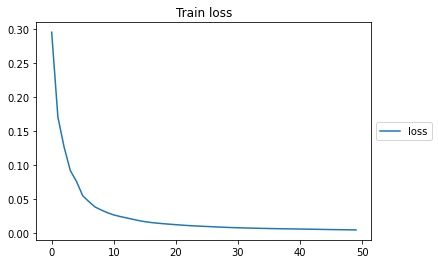

In [456]:
# Загружаем выборку digits
data = load_digits(n_class=10, return_X_y=False, as_frame=False)
X = data.images[:10]
y = data.target[:10]
train(X, y, 50)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 110.64it/s, accuracy=1, loss=0.00017]


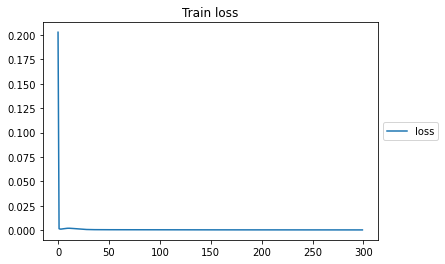

In [458]:
# Задача классификации вертикальных и горизонтальных линий
# Данные
vert1 = [[0, 0, 250, 0, 0],
         [0, 0 ,250, 0, 0],
         [0, 0 ,250, 0, 0],
         [0, 0 ,250, 0, 0],
         [0, 0 ,250, 0, 0]]

vert2 = [[0, 0, 220, 40, 0],
         [0, 0, 250, 10, 0],
         [0, 0, 250, 0, 0],
         [0, 10, 250, 0, 0],
         [0, 40, 220, 0, 0]]

hor1 = [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [250, 250, 250, 250, 250],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]

hor2 = [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 20],
        [220, 250, 250, 250, 200],
        [10, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]

data = [vert1, vert2, hor1, hor2]
labels = [0, 0, 1, 1]

X = np.array(data)
y = np.array(labels)

train(X, y, 300, num_classes=2)